In [1]:
!pip install ipython-autotime

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import os
from urllib.request import urlopen,urlretrieve
%matplotlib inline
from sklearn.utils import shuffle
import tensorflow as tf

from keras.models import load_model
from sklearn.datasets import load_files   
from keras.utils import np_utils
from glob import glob
from keras import applications
from keras.preprocessing.image import ImageDataGenerator 
from keras import optimizers
from keras.models import Sequential,Model,load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,GlobalAveragePooling2D, BatchNormalization, MaxPooling2D
from keras.callbacks import TensorBoard,ReduceLROnPlateau,ModelCheckpoint,EarlyStopping
from tqdm import tqdm
from keras.preprocessing import image
%load_ext autotime


time: 135 µs (started: 2021-09-09 05:31:52 +00:00)


LOAD DATASET FROM GOOGLE DRIVE & AUGMENTASI

Dataset source : https://www.kaggle.com/sshikamaru/fruit-recognition

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive
time: 20.2 s (started: 2021-09-09 05:31:55 +00:00)


In [4]:
!unzip "/content/drive/MyDrive/IDCAMP/Project 4 : Image Classification - Pet/Dataset2/train.zip"
!unzip "/content/drive/MyDrive/IDCAMP/Project 4 : Image Classification - Pet/Dataset2/validation.zip"

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/validation/Raspberry/._Raspberry_76.jpg  
  inflating: validation/Raspberry/Raspberry_62.jpg  
  inflating: __MACOSX/validation/Raspberry/._Raspberry_62.jpg  
  inflating: validation/Raspberry/Raspberry_89.jpg  
  inflating: __MACOSX/validation/Raspberry/._Raspberry_89.jpg  
  inflating: validation/Raspberry/Raspberry_74.jpg  
  inflating: __MACOSX/validation/Raspberry/._Raspberry_74.jpg  
  inflating: validation/Raspberry/Raspberry_60.jpg  
  inflating: __MACOSX/validation/Raspberry/._Raspberry_60.jpg  
  inflating: validation/Raspberry/Raspberry_48.jpg  
  inflating: __MACOSX/validation/Raspberry/._Raspberry_48.jpg  
  inflating: validation/Raspberry/Raspberry_49.jpg  
  inflating: __MACOSX/validation/Raspberry/._Raspberry_49.jpg  
  inflating: validation/Raspberry/Raspberry_61.jpg  
  inflating: __MACOSX/validation/Raspberry/._Raspberry_61.jpg  
  inflating: validation/Raspberry/Raspberry_75.jpg  
  inflating: 

Data train 80% dari total data => 13480 dari 16850
Data validation 20% dari total data => 3370 dari 16850

In [5]:
trdata = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range= 90)
traindata = trdata.flow_from_directory(directory="/content/train",batch_size=64,target_size=(100,100))

vddata = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range= 90)
validatedata = vddata.flow_from_directory(directory="/content/validation",batch_size=64,target_size=(100,100))

Found 13480 images belonging to 33 classes.
Found 3370 images belonging to 33 classes.
time: 668 ms (started: 2021-09-09 05:32:33 +00:00)


BUILD MODEL DENGAN ARSITEKTUR CLOUDNET

In [8]:
#Arsitektur diambil dari paper ini 
#source paper : https://www.researchgate.net/publication/326873190_CloudNet_Ground-Based_Cloud_Classification_With_Deep_Convolutional_Neural_Network

#create model
model = Sequential()
#add model layers
#Conv1 
model.add(Conv2D(96, kernel_size=11, activation='relu', input_shape=(100,100,3),strides=4))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=3,strides=2))
#conv2
model.add(Conv2D(96, kernel_size=5,activation='relu',strides=1, padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=3,strides=2))
#conv3
model.add(Conv2D(256, kernel_size=3,activation='relu',strides=1,padding='same'))
model.add(BatchNormalization())
#conv4
model.add(Conv2D(384, kernel_size=3,activation='relu',strides=1,padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=3,strides=2))
model.add(Flatten())
#fc
model.add(Dense(9216,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(33, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 23, 23, 96)        34944     
_________________________________________________________________
batch_normalization_4 (Batch (None, 23, 23, 96)        384       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 11, 11, 96)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 96)        230496    
_________________________________________________________________
batch_normalization_5 (Batch (None, 11, 11, 96)        384       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 96)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 5, 5, 256)        

In [9]:
model.compile(loss = "categorical_crossentropy", optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9,decay = 0.9), metrics=["accuracy"])

time: 9.84 ms (started: 2021-09-09 05:33:09 +00:00)


HYPERPARAMETER Cyclical Learning Rate (CLR)

In [10]:
!cp "/content/drive/My Drive/IDCAMP/Project 4 : Image Classification - Pet/learningratefinder.py" . 
!cp "/content/drive/My Drive/IDCAMP/Project 4 : Image Classification - Pet/clr_callback.py" .
from learningratefinder import LearningRateFinder
from clr_callback import CyclicLR

time: 774 ms (started: 2021-09-09 05:33:14 +00:00)


[INFO] finding learning rate...
Epoch 1/4
211/211 [==============================] - 75s 214ms/step - loss: 4.9575 - accuracy: 0.0302
Epoch 2/4
211/211 [==============================] - 45s 215ms/step - loss: 4.9840 - accuracy: 0.0280
Epoch 3/4
211/211 [==============================] - 46s 216ms/step - loss: 4.7109 - accuracy: 0.0356
Epoch 4/4
211/211 [==============================] - 45s 214ms/step - loss: 2.2501 - accuracy: 0.3891
[INFO] learning rate finder complete


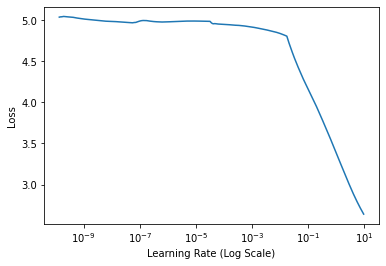

time: 3min 32s (started: 2021-09-09 05:33:36 +00:00)


In [11]:
#Disini CLR digunakan agar learning rate berubah2 seiring proses training, hal ini dilakukan untuk mencegah model berada pada saddle point dan local minima

#source : https://arxiv.org/abs/1506.01186

print("[INFO] finding learning rate...")
lrf = LearningRateFinder(model)
lrf.find(traindata,1e-10, 1e+1,stepsPerEpoch=np.ceil((13480/float(64))),batchSize=64,epochs=4)
lrf.plot_loss()

print("[INFO] learning rate finder complete")

In [12]:
# Set CLR options
base_lr = 1e-2
max_lr = 0.5
mode='triangular'

# Define the callback
clr = CyclicLR(base_lr=base_lr, max_lr=max_lr, mode=mode)

time: 2.37 ms (started: 2021-09-09 05:37:39 +00:00)


TRAINING & VALIDATION

In [13]:
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=25, verbose=1, mode='auto')
callbacks_list = [clr,early]
history = model.fit_generator(generator= traindata, epochs= 100, validation_data= validatedata, validation_steps=1, callbacks=callbacks_list)

#Callback pertama yaitu CLR, dan yang kedua earlystopping.

#Early Stopping digunakan untuk mengentikan proses training ketika akurasi tidak lagi naik pada sekian epoch yang ditentukan.
#Disini saya melakukan training dengan 100 epoch dan patience 25, yaitu ketika 25 epoch akurasi tidak naik maka proses training akan dihentikan.

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
211/211 [==============================] - 47s 220ms/step - loss: 4.3281 - accuracy: 0.1875 - val_loss: 2.1963 - val_accuracy: 0.4062
Epoch 2/100
211/211 [==============================] - 46s 218ms/step - loss: 1.6220 - accuracy: 0.4864 - val_loss: 0.8068 - val_accuracy: 0.8594
Epoch 3/100
211/211 [==============================] - 46s 219ms/step - loss: 0.8801 - accuracy: 0.7102 - val_loss: 0.4643 - val_accuracy: 0.9062
Epoch 4/100
211/211 [==============================] - 46s 218ms/step - loss: 0.5769 - accuracy: 0.8119 - val_loss: 0.3739 - val_accuracy: 0.8906
Epoch 5/100
211/211 [==============================] - 46s 219ms/step - loss: 0.3870 - accuracy: 0.8741 - val_loss: 0.2482 - val_accuracy: 0.9219
Epoch 6/100
211/211 [==============================] - 46s 218ms/step - loss: 0.2705 - accuracy: 0.9134 - val_loss: 0.3815 - val_accuracy: 0.8906
Epoch 7/100
211/211 [==============================] - 46s 218ms/step - loss: 0.2032 - accuracy: 0.9367 - val_loss: 0.3124 -

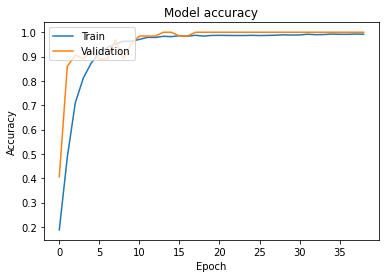

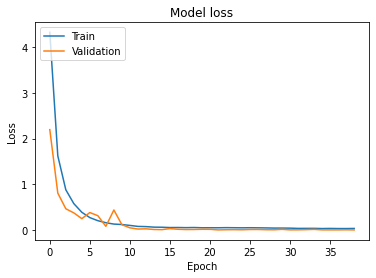

time: 35.8 s (started: 2021-09-09 06:07:51 +00:00)


In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Save to TFLite Model

In [19]:
#source : https://www.tensorflow.org/lite/convert
converter = tf.lite.TFLiteConverter.from_keras_model(model)
fruit_tflite = converter.convert()

with open('model_fruit.tflite', 'wb') as f:
  f.write(fruit_tflite)

INFO:tensorflow:Assets written to: /tmp/tmpkn8ejrhq/assets


INFO:tensorflow:Assets written to: /tmp/tmpkn8ejrhq/assets


time: 8.25 s (started: 2021-09-09 06:14:52 +00:00)
